# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

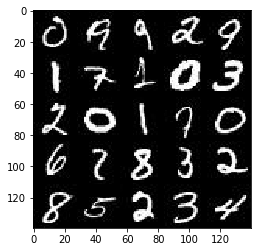

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

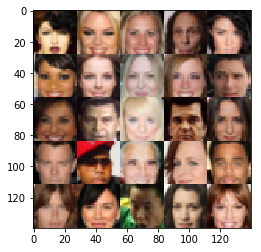

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real'),
            tf.placeholder(tf.float32, (None, z_dim), name='input_z'), 
            tf.placeholder(tf.float32, name='learning_rate'))
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    keep_prob = 0.7
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.maximum(alpha * h, h)
        
        h = tf.layers.conv2d(h, 128, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha * h, h)
        h = tf.nn.dropout(h, keep_prob)
        
        h = tf.layers.conv2d(h, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha * h, h)
        
        h = tf.layers.conv2d(h, 512, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())   
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.maximum(alpha*h, h)
        h = tf.nn.dropout(h, keep_prob)
        
        logits = tf.layers.dense(tf.reshape(h, (-1, 7*7*256)), 1)
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.75
    with tf.variable_scope('generator', reuse=not is_train):
        h = tf.layers.dense(z, 7*7*512)
        
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        h = tf.nn.dropout(h, keep_prob)
        
        h = tf.layers.conv2d_transpose(h, 256, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        
        
        h = tf.layers.conv2d_transpose(h, 128, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        h = tf.nn.dropout(h, keep_prob)
       
        
        h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
       
        logits = tf.layers.conv2d_transpose(h, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
       
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * 0.9))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_count = 0
    
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 2.1866
Epoch 1/2... Discriminator Loss: 4.9342... Generator Loss: 0.0769
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 0.6862... Generator Loss: 5.4787
Epoch 1/2... Discriminator Loss: 0.6031... Generator Loss: 6.0360
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 1.9551
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 1.2365
Epoch 1/2... Discriminator Loss: 0.5236... Generator Loss: 2.9292
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.6844
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 3.3280


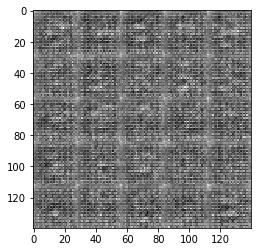

Epoch 1/2... Discriminator Loss: 1.8107... Generator Loss: 4.0782
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 1.7051
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 2.8708
Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 1.3537
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 1.1271
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 1.9079
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 1.5853
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 2.4976
Epoch 1/2... Discriminator Loss: 0.7913... Generator Loss: 1.9713
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.8765


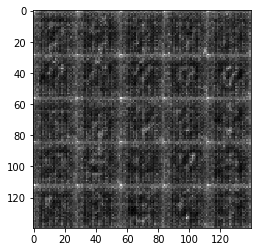

Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 1.3545
Epoch 1/2... Discriminator Loss: 1.7373... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.9767
Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 1.7233
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 3.8166
Epoch 1/2... Discriminator Loss: 2.0440... Generator Loss: 4.5966
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.7238
Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 1.5482
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.7219


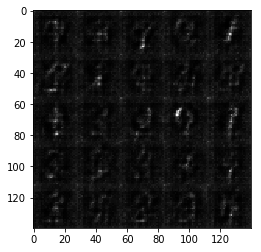

Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 3.0803
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 2.3278
Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 4.0767
Epoch 1/2... Discriminator Loss: 0.9013... Generator Loss: 1.3882
Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 2.2951
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 3.1398
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 1.1633
Epoch 1/2... Discriminator Loss: 1.8259... Generator Loss: 4.7322
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 2.1814
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.5391


Epoch 1/2... Discriminator Loss: 0.6564... Generator Loss: 1.9440
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 2.9442... Generator Loss: 0.1598
Epoch 1/2... Discriminator Loss: 0.7846... Generator Loss: 2.0217
Epoch 1/2... Discriminator Loss: 0.7237... Generator Loss: 2.1524
Epoch 1/2... Discriminator Loss: 0.7508... Generator Loss: 2.2419
Epoch 1/2... Discriminator Loss: 0.7437... Generator Loss: 2.1110
Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 1.8191
Epoch 1/2... Discriminator Loss: 0.6562... Generator Loss: 1.9733
Epoch 1/2... Discriminator Loss: 2.6747... Generator Loss: 0.2141


Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.2601
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 2.7593
Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 1.6589
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 3.5623
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 2.3850
Epoch 1/2... Discriminator Loss: 0.7470... Generator Loss: 1.9350
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 0.7280... Generator Loss: 1.9475
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 1.2845
Epoch 1/2... Discriminator Loss: 0.6931... Generator Loss: 1.8253


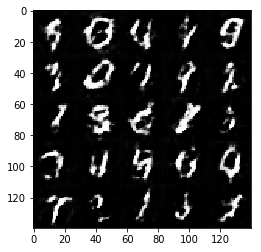

Epoch 1/2... Discriminator Loss: 0.6598... Generator Loss: 1.9088
Epoch 1/2... Discriminator Loss: 1.9690... Generator Loss: 4.3847
Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 1.6067
Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 1.8082
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 0.6740... Generator Loss: 2.1561
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 2.4187
Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 1.4312... Generator Loss: 2.9029
Epoch 1/2... Discriminator Loss: 1.3498... Generator Loss: 2.7320


Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.9990
Epoch 1/2... Discriminator Loss: 0.8318... Generator Loss: 1.7213
Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 2.1307
Epoch 1/2... Discriminator Loss: 0.6915... Generator Loss: 2.0620
Epoch 1/2... Discriminator Loss: 0.6414... Generator Loss: 2.1215
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.1546
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 2.6371
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 2.5069
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.5475


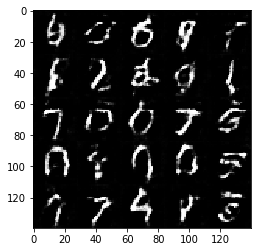

Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 3.0266
Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 1.6024
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 2.3463
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 0.7164... Generator Loss: 1.7192
Epoch 1/2... Discriminator Loss: 0.6409... Generator Loss: 2.0011
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 1.1447
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 3.0541
Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 1.8822


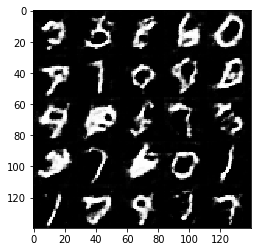

Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 0.6315... Generator Loss: 1.9462
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 2.9112
Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 1.3266
Epoch 2/2... Discriminator Loss: 1.0018... Generator Loss: 1.1342
Epoch 2/2... Discriminator Loss: 0.9430... Generator Loss: 1.2192
Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 3.5126
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 2.1974
Epoch 2/2... Discriminator Loss: 0.6698... Generator Loss: 1.9283


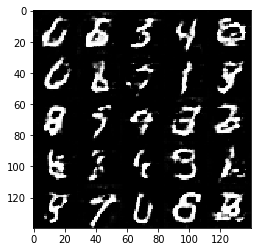

Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 2.1599
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 2.1288
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 3.8837
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 2.1145
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.6686
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 1.9376
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 1.4472
Epoch 2/2... Discriminator Loss: 0.5048... Generator Loss: 2.9279
Epoch 2/2... Discriminator Loss: 1.8524... Generator Loss: 0.4841
Epoch 2/2... Discriminator Loss: 2.4073... Generator Loss: 0.3223


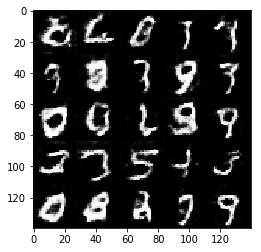

Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.6905
Epoch 2/2... Discriminator Loss: 0.6372... Generator Loss: 2.4201
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.6591
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.3901
Epoch 2/2... Discriminator Loss: 0.9302... Generator Loss: 2.3786
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.5655
Epoch 2/2... Discriminator Loss: 1.6417... Generator Loss: 3.9507
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 2.2593
Epoch 2/2... Discriminator Loss: 0.5763... Generator Loss: 2.1084
Epoch 2/2... Discriminator Loss: 0.6931... Generator Loss: 1.7654


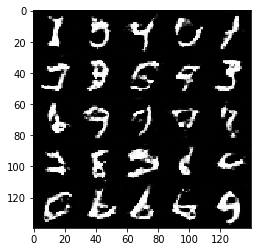

Epoch 2/2... Discriminator Loss: 0.8324... Generator Loss: 1.4428
Epoch 2/2... Discriminator Loss: 1.4549... Generator Loss: 2.7748
Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.2837
Epoch 2/2... Discriminator Loss: 1.8685... Generator Loss: 0.5582
Epoch 2/2... Discriminator Loss: 0.5187... Generator Loss: 2.8982
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.9555
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 3.6812
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 2.0094
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 2.5968


Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.8036
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 1.2759
Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 1.7257
Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 1.8146
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 2.3502
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 1.6919
Epoch 2/2... Discriminator Loss: 0.6068... Generator Loss: 1.5111
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 2.6188
Epoch 2/2... Discriminator Loss: 1.8305... Generator Loss: 4.1277


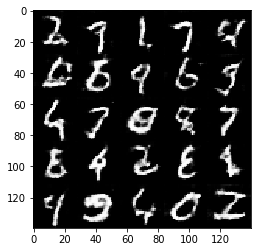

Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 2.0273
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 2.0271
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 2.0166
Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 2.6460
Epoch 2/2... Discriminator Loss: 1.0449... Generator Loss: 1.1598
Epoch 2/2... Discriminator Loss: 0.6216... Generator Loss: 3.0331
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 1.9382
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.9549
Epoch 2/2... Discriminator Loss: 0.4650... Generator Loss: 2.8248
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 2.6406


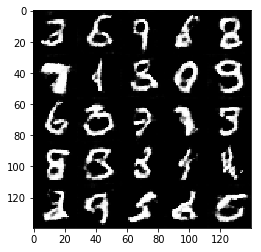

Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.4141
Epoch 2/2... Discriminator Loss: 0.6852... Generator Loss: 1.6605
Epoch 2/2... Discriminator Loss: 0.5752... Generator Loss: 2.0869
Epoch 2/2... Discriminator Loss: 1.8781... Generator Loss: 0.5480
Epoch 2/2... Discriminator Loss: 0.8635... Generator Loss: 1.6012
Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 2.7022
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.5276
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.8601
Epoch 2/2... Discriminator Loss: 0.5833... Generator Loss: 1.9189


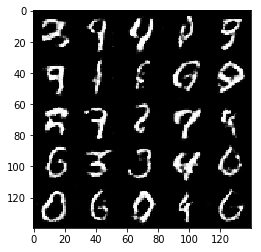

Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 2.2588
Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 3.8913
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.6351
Epoch 2/2... Discriminator Loss: 0.6137... Generator Loss: 2.4965
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 2.4308
Epoch 2/2... Discriminator Loss: 1.8982... Generator Loss: 0.4296
Epoch 2/2... Discriminator Loss: 0.5674... Generator Loss: 2.1426
Epoch 2/2... Discriminator Loss: 0.5455... Generator Loss: 2.2961
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 2.6901
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 1.1533


Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 2.1703
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 2.0204
Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 2.1104
Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 2.5847
Epoch 2/2... Discriminator Loss: 2.2719... Generator Loss: 0.2520
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.5557
Epoch 2/2... Discriminator Loss: 0.6549... Generator Loss: 1.6784
Epoch 2/2... Discriminator Loss: 0.6265... Generator Loss: 2.9454
Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 2.4915


Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 2.2076
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 2.4943
Epoch 2/2... Discriminator Loss: 0.5700... Generator Loss: 2.1129
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.9743
Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 2.3066
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 1.1035


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 5.3965
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 3.6758
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 5.1754
Epoch 1/1... Discriminator Loss: 3.6742... Generator Loss: 0.1618
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 6.3808
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 2.7081
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 4.4694
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 3.5550


Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 2.6228
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 2.8336
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 2.1818... Generator Loss: 7.8233
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 2.0441
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 1.7920
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 4.3438
Epoch 1/1... Discriminator Loss: 0.6302... Generator Loss: 2.7124
Epoch 1/1... Discriminator Loss: 1.6710... Generator Loss: 0.5949


Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 3.3525
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 3.0476
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 3.2442
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 2.2282
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 2.5504
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 2.1764... Generator Loss: 0.5007


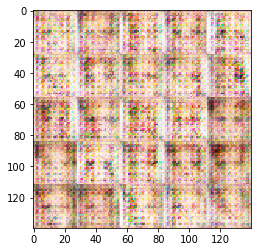

Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.4552
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 3.2693
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 3.3208
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 2.7592
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.8790
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 3.5508
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.7141... Generator Loss: 1.8715
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.7296


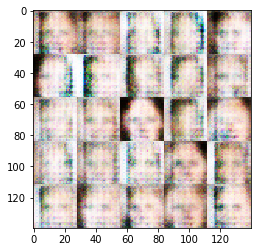

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 2.1730
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 5.2508
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 2.1689... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.6117
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 2.0678


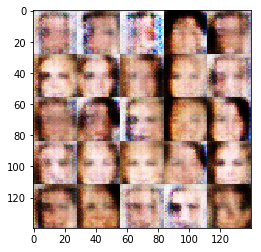

Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 2.0876... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 2.7272
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 2.4621
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 3.5955
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 2.0149
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 2.6164


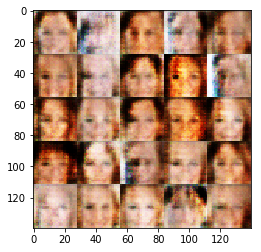

Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 3.1867
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 2.6561
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 1.7056
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.5661
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.8351


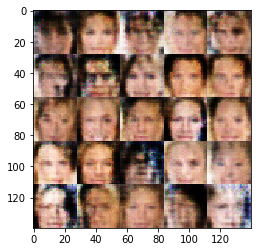

Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.3882
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 2.8579
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8707


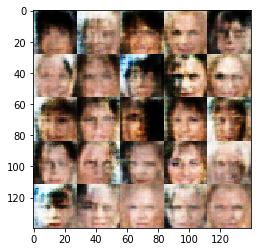

Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 1.7669
Epoch 1/1... Discriminator Loss: 1.8464... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.8428
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 1.3257


Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 3.6017
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 2.2962
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 2.8052
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.4372


Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.4719
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.1254


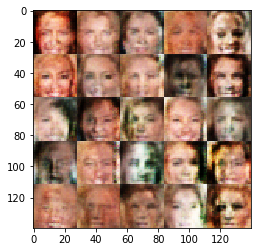

Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 2.6967
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.8514
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.3369
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.6049
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.2754


Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.6886
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.9673
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 2.5794
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.6725
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.9072
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.8740


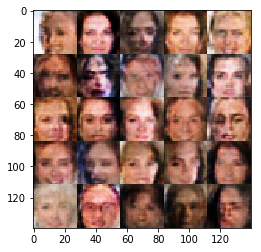

Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 2.3662
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.6177
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.5647
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.2807
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 2.1587
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.0800


Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 1.8292... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.6985
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.3961


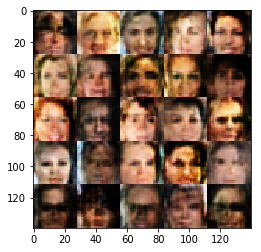

Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 2.2876
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 2.3390
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 2.1297
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8255


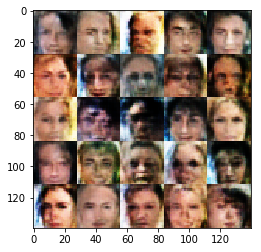

Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.5232
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 2.0451
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.5091
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 2.9204
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.9732


Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 2.3639
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.9842
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 3.1018
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.3960


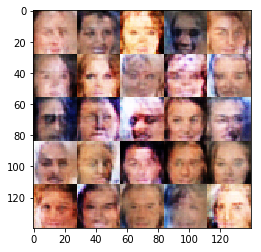

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.3940
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.1562


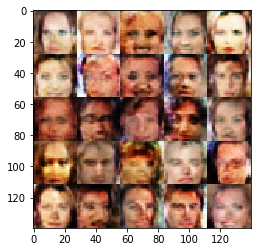

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 2.7463
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 2.3452
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.8809
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.7952


Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.5452
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 2.3846
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.1246


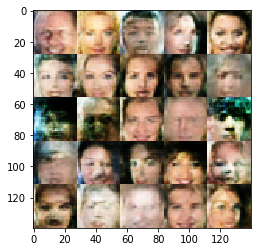

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.9402
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.8822


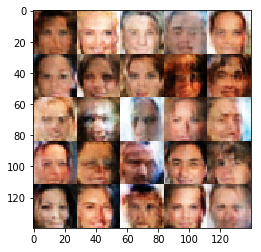

Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.5253
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.7344
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.6309


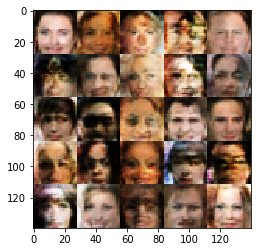

Epoch 1/1... Discriminator Loss: 1.7451... Generator Loss: 0.4356
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 2.6633
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.7378
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 2.7441


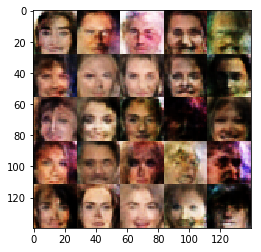

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 2.3403
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.9359... Generator Loss: 3.1165
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.8810


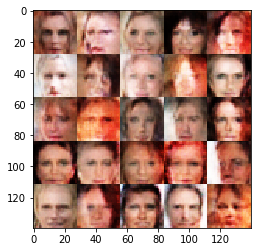

Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.9839
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 2.1921
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 2.2882
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.8368


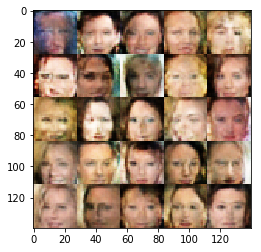

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.7405


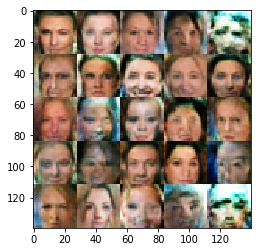

Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.8956


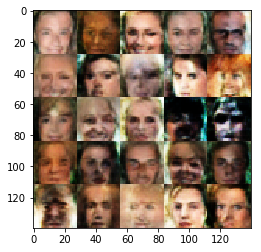

Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.5891
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.8468
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.4465


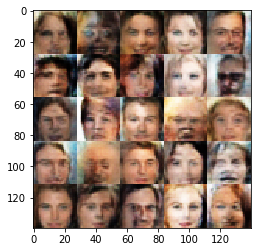

Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 2.4162
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.8401
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.5401
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.5070


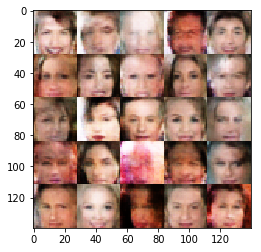

Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 2.2326
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.5701
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.9820


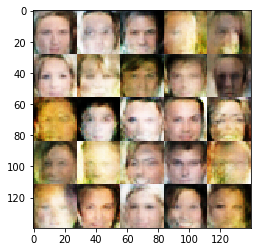

Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 2.1432
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.3441
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 2.4899
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 2.0466


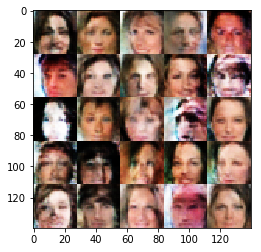

Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.6128
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.7928
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.7668
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.4338
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 2.6355


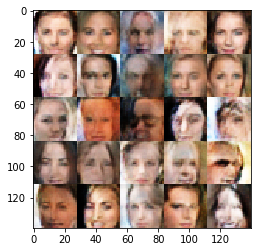

Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.5100
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.9667


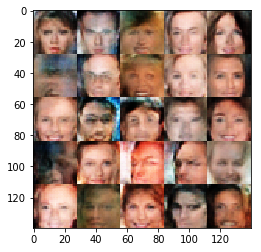

Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 2.1793
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 2.0712
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 2.2680
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.5818


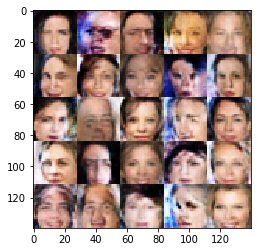

Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.3203
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.8154
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8616


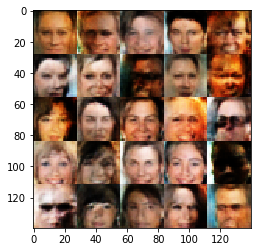

Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.5786
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.3433
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.7421


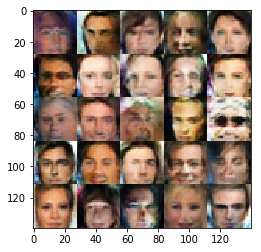

Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.7432
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.1567


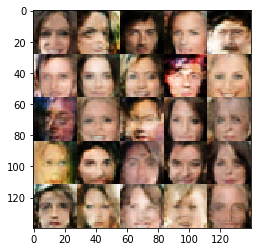

Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.3604
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 2.9913
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.6382
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 2.3933
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6741


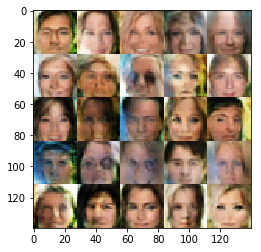

Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 2.1314
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 2.3500


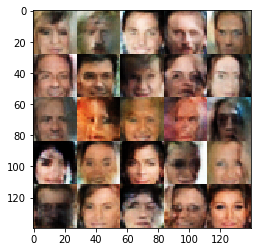

Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.4471
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.7809
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.5918
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.5270
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 2.6231
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 2.0702


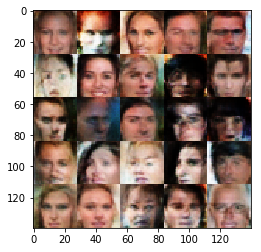

Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.3977
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 1.5717


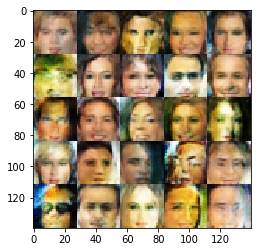

Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.5081
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.9825
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.2906
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.7451
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.5011


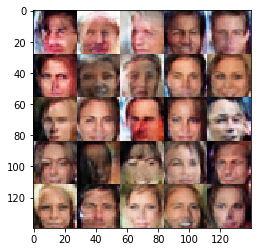

Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 2.0917
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.8601
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 1.7343
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.2283


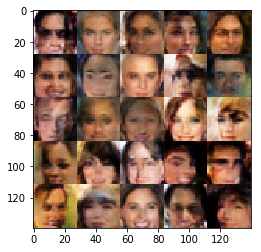

Epoch 1/1... Discriminator Loss: 0.8551... Generator Loss: 1.3006
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.2674
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.8987
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6478


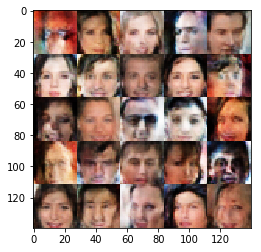

Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.3471
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 1.5660
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 2.5478
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.3998
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 2.4210


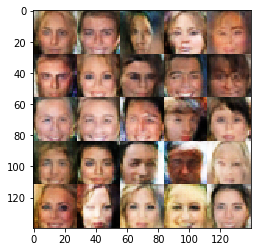

Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.2005
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 2.9303
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.6672


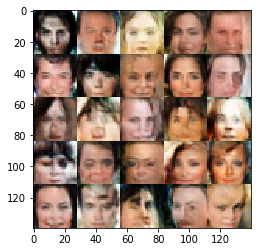

Epoch 1/1... Discriminator Loss: 1.8027... Generator Loss: 0.3511
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 3.1141
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.5663
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.0404


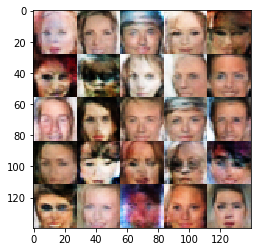

Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.2214
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.5215
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.6079
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.4641
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 2.6615
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7573


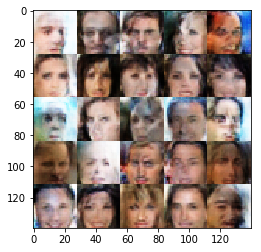

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 2.9359
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.3375
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.2850


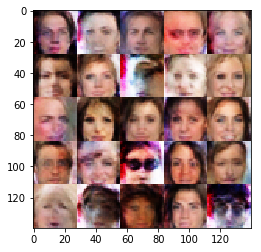

Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 3.6254
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 2.2824
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.5936
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.2648
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5307


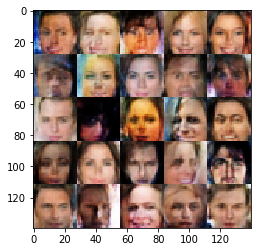

Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 2.1598
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.5365
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 2.5989


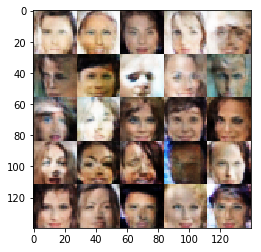

Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 2.1774
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.0201


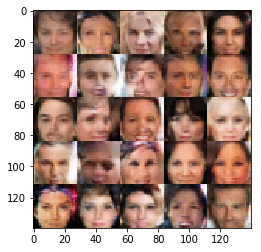

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.1791
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.9088
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.4448
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 2.4636
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.9706


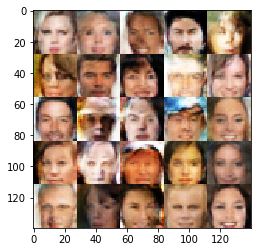

Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 3.5823
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 0.6731... Generator Loss: 1.8869
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 2.4632
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 3.6943


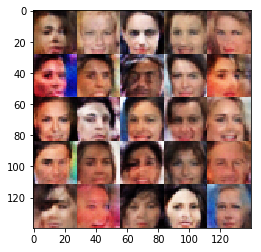

Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.9546
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.7616
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 2.6376
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 2.4542
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.0605


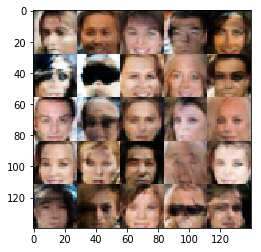

Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 2.3221
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.4744


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.